# Demo RNA Multi-Perceptrón Backpropagation usando Keras para procesar imágenes e identificar TIPOS de caracteres Chinos de Números

1) Cargar librerías:

In [1]:
#@title Librerías a usar
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

from keras.utils import np_utils

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Definir los parámetros:

In [2]:
## selección de los parámetros 

# 
#@markdown ### Parámetros de imágenes:
imagen_largo_ancho =  40#@param {type:"integer"}
imagen_color = False 
imagen_usar_generadas_data_augmentation = True 

#@markdown ### Parámetros de la red:
rna_cant_neuronas_capas_ocultas = '800, 400, 200' #@param {type:"string"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]
rna_cant_epocas_entrenamiento =  200#@param {type:"integer"}
rna_learning_rate_entrenamiento = 0.001 #@param {type:"number"}


## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# cantidad de neuronas ocultas 
##hidden_layers = [ num_inputs//5, num_inputs//20, num_inputs//100 ]
hidden_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  hidden_layers.append( int(val) )

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')

# cantidad de épocas del entrenamiento
cantEpocas = (100 if rna_cant_epocas_entrenamiento<1 else rna_cant_epocas_entrenamiento)

print ("Tamaño Imagen: ", IMAGE_SHAPE)
print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, ("Softmax" if tipo_output_softMax else "Dense[1] "))

Tamaño Imagen:  (40, 40, 1)
Configuración de RNA MLP Backpropagation definida: [ 1600 [800, 400, 200] Softmax


3) Montar el Drive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/IA-RNA/ImagenesNrosChinos' #@param {type:"string"}


Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

> Imágenes Originales: 
-  Número  1


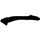

-  Número  2


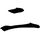

-  Número  3


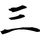

-  Número  4


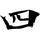

-  Número  5


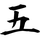

-  Número  6


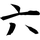

-  Número  7


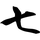

-  Número  8


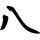

-  Número  9


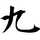

-  Número 10


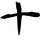



> procesando  /content/temp_NrosChinos/train : 
  --  /content/temp_NrosChinos/auxi/Número  3 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  4 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  5 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  8 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  9 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  1 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  6 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número 10 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  7 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  2 : 
Found 1 images belonging to 1 classes.

 Mostrando imágenes de  /content/temp_NrosChinos/train :
 -

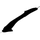

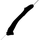

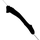

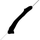

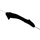

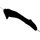

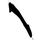

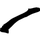

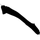

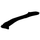

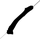

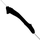

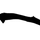

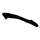

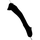

 -  Número  2 :


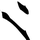

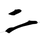

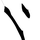

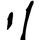

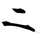

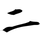

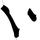

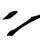

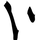

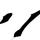

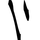

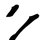

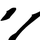

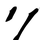

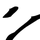

 -  Número  3 :


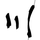

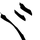

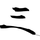

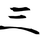

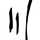

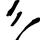

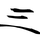

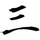

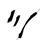

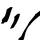

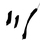

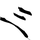

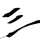

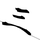

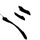

 -  Número  4 :


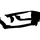

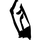

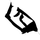

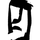

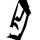

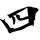

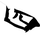

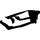

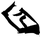

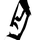

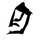

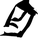

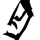

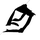

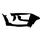

 -  Número  5 :


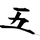

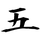

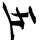

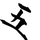

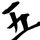

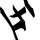

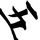

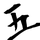

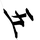

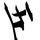

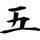

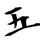

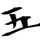

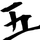

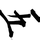

 -  Número  6 :


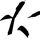

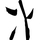

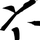

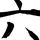

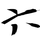

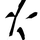

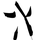

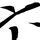

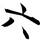

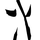

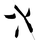

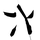

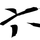

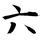

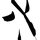

 -  Número  7 :


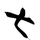

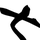

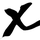

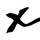

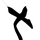

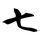

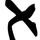

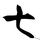

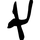

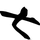

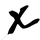

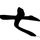

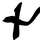

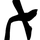

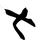

 -  Número  8 :


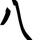

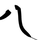

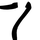

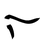

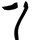

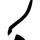

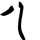

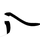

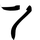

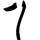

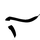

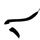

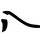

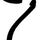

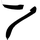

 -  Número  9 :


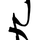

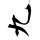

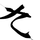

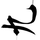

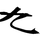

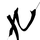

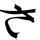

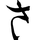

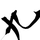

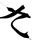

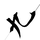

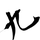

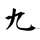

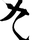

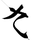

 -  Número 10 :


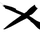

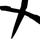

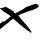

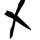

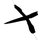

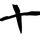

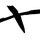

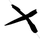

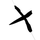

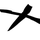

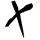

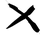

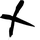

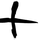

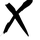



> procesando  /content/temp_NrosChinos/test : 
  --  /content/temp_NrosChinos/auxi/Número  3 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  4 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  5 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  8 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  9 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  1 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  6 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número 10 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  7 : 
Found 1 images belonging to 1 classes.
  --  /content/temp_NrosChinos/auxi/Número  2 : 
Found 1 images belonging to 1 classes.


In [4]:
#@title Aplicar Data Augmentation sobre las imágenes cargadas para generar diversidad

#@markdown Cantidades a generar por DA:
cantidad_imagenes_entrenamiento =  15#@param {type:"integer"}
cantidad_imagenes_prueba = 3 #@param {type:"integer"}
#@markdown Parámeteros para DA:
da_rotation_range=90 #@param {type:"integer"}
da_shear_range = 0.3 #@param {type:"number"}
da_zoom_range = 0.3  #@param {type:"number"}
da_horizontal_flip = False  #@param {type:"boolean"}
da_vertical_flip = False #@param {type:"boolean"}
#@markdown Mostrar imágenes generadas por DA:
mostrar_imagenes_entrenamiento_generadas_da = True #@param {type:"boolean"}
mostrar_imagenes_prueba_generadas_da = False #@param {type:"boolean"}

def mostrarImagen(imagPathName):
    # muesta la imagen
    imag = Image.open(imagPathName) 
    if IMAGE_SHAPE[2]==1:              
      tipoImage = 'L'
    else:                
      tipoImage = 'RGB'
    imag = imag.convert(tipoImage)
    imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
    display( imag )

def mostrarTodasImagenes(imagPath):
  print("\n Mostrando imágenes de ", imagPath, ":")
  all_dirs = os.listdir( imagPath )
  all_dirs.sort()
  for each_dir in all_dirs:
      print(" - ", each_dir, ":")
      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:
          mostrarImagen(auxiPath + "/" + each_imagFN) 

# organiza las imágenes en direvtgorios
def organizarImagenes(imagPath, destinoPath):

  #genera directorio de salida si no existe
  if not os.path.exists(destinoPath):
    os.makedirs(destinoPath)

  print("> Imágenes Originales: ")

  # procesa las imágenes
  all_images = os.listdir( imagPath )
  all_images.sort()
  for each_imag in all_images:

    img_name = os.path.splitext(each_imag)[0]
                
    # muesta la imagen
    print("- ", img_name)
    mostrarImagen(imagPath + "/" + each_imag) 

    # genera directorio de salida si no existe    
    auxiDestPath = destinoPath + '/' + img_name 
    if not os.path.exists(auxiDestPath):
        os.makedirs(auxiDestPath)

        shutil.copy(imagPath+'/'+each_imag, auxiDestPath)

 
# Parámetros:
#       image_generator: el generador de imágenes
#       imagPath: el directorio base a procesar
#       destinoPath: el directorio base donde se va a guardar la nueva imagen
def procesarImagenes(image_generator, imagPath, destinoPath, cantidadGenerar):

  print("\n\n> procesando ", destinoPath, ": ")

  #genera directorio de salida si no existe
  if not os.path.exists(destinoPath):
    os.makedirs(destinoPath)

  # procesa los subdirectorios con las imágenes
  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

    auxiPath = imagPath + '/' + each_dir 
    print("  -- ", auxiPath, ": ")

    # obtiene la cantidad de imágenes disponibles
    cantImagDir = len(os.listdir( auxiPath ))

    # genera directorio de salida si no existe
    auxiDestPath = destinoPath + '/' + each_dir 
    if not os.path.exists(auxiDestPath):
        os.makedirs(auxiDestPath)

    # carga las imágenes a procesar
    image_data = image_generator.flow_from_directory(str(imagPath), 
                                                      classes=[each_dir],
                                                      save_to_dir=auxiDestPath,
                                                      save_prefix='da_'+each_dir)
    
    for i in range(cantidadGenerar):
      # genera las imagenes
      image_data.next()




# borra directorio de salida temporal si existe
tempDir = '/content/temp_NrosChinos'
if os.path.exists(tempDir):
  shutil.rmtree(tempDir)

# genera directorio auxiliar apara organizar las imágenes 
imagPath_auxi = tempDir+'/auxi'
organizarImagenes(path, imagPath_auxi)


# define el generador con los tipos de "augmentations" a apicar
image_generator =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                  rotation_range=da_rotation_range,
                                                                  shear_range = da_shear_range,
                                                                  zoom_range = da_zoom_range,
                                                                  horizontal_flip = da_horizontal_flip,
                                                                  vertical_flip = da_vertical_flip)




# genera imágenes de entrenamiento
imagPath_train = tempDir+'/train'
procesarImagenes(image_generator, imagPath_auxi, imagPath_train, cantidad_imagenes_entrenamiento)
if mostrar_imagenes_entrenamiento_generadas_da:
  mostrarTodasImagenes(imagPath_train)

# genera imágenes de prueba
imagPath_test = tempDir+'/test'
procesarImagenes(image_generator, imagPath_auxi, imagPath_test, cantidad_imagenes_prueba)
if mostrar_imagenes_prueba_generadas_da:
  mostrarTodasImagenes(imagPath_test)



> Para Entrenamiento: 
- Clases cargadas:  150
- Imágenes cargadas:  150
- Ejemplo  Número  1   (40, 40) : 


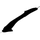



> Para Prueba: 
- Clases cargadas:  30
- Imágenes cargadas:  30
- Ejemplo  Número  1   (40, 40) : 


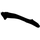

In [5]:
#@title Cargar imágenes
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  all_dirs.sort()
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
            
            if usarDA or (not esImagDA): 
                
                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)
                
                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:              
                  tipoImage = 'L'
                else:                
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
                
                # transforma a un vector de nros
                arImag = np.array(imag)
                
                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (150, 1600)
 - y_trainEnc (cant):  150


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (30, 1600)
 - y_testEnc (cant):  30


> Para Ambos: 
 - dictMapeo:  {'Número  4': 0, 'Número  1': 1, 'Número  8': 2, 'Número  2': 3, 'Número  7': 4, 'Número  9': 5, 'Número 10': 6, 'Número  5': 7, 'Número  3': 8, 'Número  6': 9}
 - clases_map:  ['Número  4', 'Número  1', 'Número  8', 'Número  2', 'Número  7', 'Número  9', 'Número 10', 'Número  5', 'Número  3', 'Número  6']

 - Imagen reconstruida de  Número  1 ( 1  /  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] )


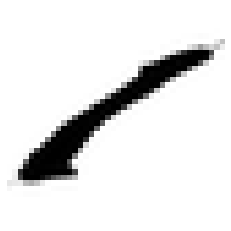

In [6]:
#@title Preparar imágenes
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases 
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
if tipo_output_softMax:
  print(" - y_trainEnc (cant): ", len(y_trainEnc))
else:
  print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
if tipo_output_softMax:
  print(" - y_testEnc (cant): ", len(y_testEnc))
else:
  print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

5) Establecer el modelo para la RNA:

Modelo creado con  5  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 1600)]            0         
_________________________________________________________________
hidd_1 (Dense)               (None, 800)               1280800   
_________________________________________________________________
hidd_2 (Dense)               (None, 400)               320400    
_________________________________________________________________
hidd_3 (Dense)               (None, 200)               80200     
_________________________________________________________________
output (Dense)               (None, 10)                2010      
Total params: 1,683,410
Trainable params: 1,683,410
Non-trainable params: 0
_________________________________________________________________




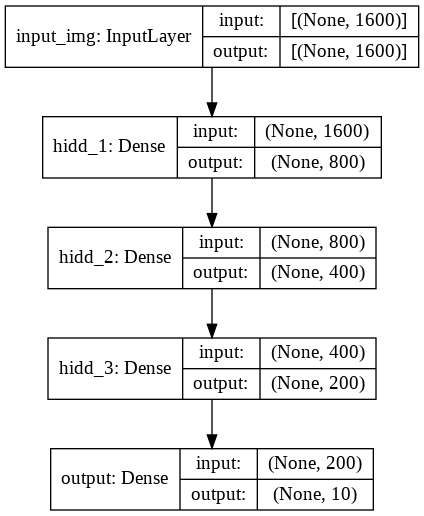

In [7]:
#@title Establecer modelo

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  

    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, activation="sigmoid", name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = Dense(units = len(dictMapeo), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = Dense(1, activation=None, name='output')(eachLay) # capa de salida


# Gradiente Decreciente
opt = keras.optimizers.Adam(learning_rate=rna_learning_rate_entrenamiento)

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


6) Entrenar el modelo de la RNA:

In [8]:
#@title Entrenar

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")



# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,) )

print("\n>Entrenamiento Finalizado.")



> De los  150 ejemplos de entrenamiento: 
            se usan  135 ejemplos para entrenar 
            y  15 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/200
5/5 [==============================] - 1s 91ms/step - loss: 2.4957 - accuracy: 0.0976 - val_loss: 2.4273 - val_accuracy: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - loss: 2.3998 - accuracy: 0.0942 - val_loss: 2.4596 - val_accuracy: 0.0000e+00
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 2.3191 - accuracy: 0.1081 - val_loss: 2.4948 - val_accuracy: 0.0000e+00
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 2.2881 - accuracy: 0.1897 - val_loss: 2.3893 - val_accuracy: 0.0000e+00
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 2.2820 - accuracy: 0.1246 - val_loss: 2.3679 - val_accuracy: 0.0000e+00
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 2.2519 - accuracy: 0.1429 - val_loss: 2.3509 - val

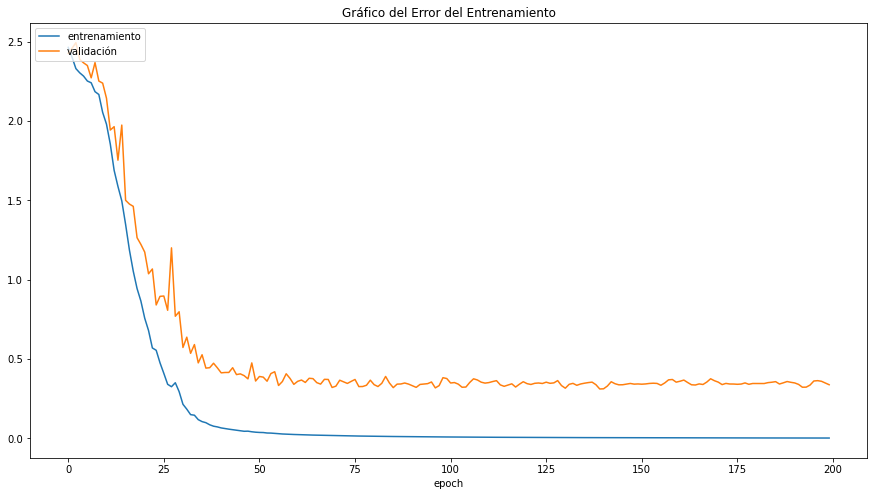

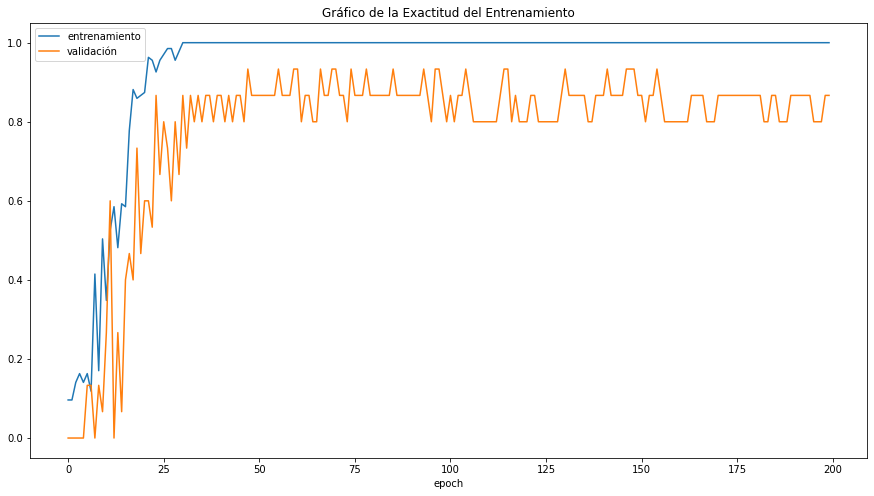

In [9]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [10]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_por_imagen = False #@param {type:"boolean"}

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, mostarImagenes=True):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:      
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'    

        if mostarImagenes:
            # muestra comparación con la imagen
            fig = plt.figure()
            fig.suptitle( strTitulo )
            ax1 = fig.add_subplot(121)
            plot_image( x[i] )
            
            plt.tight_layout()
            fig = plt.gcf()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    # ordena las renglones y columnas
    cmtx = cmtx.sort_index()
    cols = list(cmtx.columns.values)
    cols.sort()
    # muestra la matriz
    display(cmtx[cols])
    print("\n")
    
    if mostarImagenes:
      print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, esDAimag_train, clases_map, mostrar_detalle_por_imagen)


*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

  Número  1       1.00      1.00      1.00        15
  Número  2       0.94      1.00      0.97        15
  Número  3       1.00      1.00      1.00        15
  Número  4       1.00      1.00      1.00        15
  Número  5       1.00      1.00      1.00        15
  Número  6       1.00      1.00      1.00        15
  Número  7       0.94      1.00      0.97        15
  Número  8       1.00      1.00      1.00        15
  Número  9       1.00      0.93      0.97        15
  Número 10       1.00      0.93      0.97        15

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150


Matriz de Confusión: 


,p:Número 1,p:Número 2,p:Número 3,p:Número 4,p:Número 5,p:Número 6,p:Número 7,p:Número 8,p:Número 9,p:Número 10
r:Número 1,15,0,0,0,0,0,0,0,0,0
r:Número 2,0,15,0,0,0,0,0,0,0,0
r:Número 3,0,0,15,0,0,0,0,0,0,0
r:Número 4,0,0,0,15,0,0,0,0,0,0
r:Número 5,0,0,0,0,15,0,0,0,0,0
r:Número 6,0,0,0,0,0,15,0,0,0,0
r:Número 7,0,0,0,0,0,0,15,0,0,0
r:Número 8,0,0,0,0,0,0,0,15,0,0
r:Número 9,0,1,0,0,0,0,0,0,14,0
r:Número 10,0,0,0,0,0,0,1,0,0,14


7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

1/1 [==============================] - 0s 16ms/step - loss: 0.6282 - accuracy: 0.8000

>Evaluación del Modelo: 
    - Error:  0.6281865835189819
    - Exactitud:  80.0000011920929




*** Resultados con datos de Prueba: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Reporte de Clasificación: 
              precision    recall  f1-score   support

  Número  1       1.00      0.67      0.80         3
  Número  2       1.00      0.67      0.80         3
  Número  3       1.00      0.67      0.80         3
  Número  4       0.75      1.00      0.86         3
  Número  5       0.60      1.00      0.75         3
  Número  6       0.50      0.33      0.40         3
  Número  7       1.00      0.67      0.80         3
  Número  8       1.00      1.00      1.00         3
  Número  9       0.60      1.00      0.75         3
  Número 10       1.00      1.00      1.00         3

    accuracy                           0.80        30
   macro avg       0.84      0.80      0.80        30
weighted avg       0.85      0.80      0.80        30


Matriz de Confusión: 


,p:Número 1,p:Número 2,p:Número 3,p:Número 4,p:Número 5,p:Número 6,p:Número 7,p:Número 8,p:Número 9,p:Número 10
r:Número 1,2,0,0,0,1,0,0,0,0,0
r:Número 2,0,2,0,0,0,1,0,0,0,0
r:Número 3,0,0,2,0,0,0,0,0,1,0
r:Número 4,0,0,0,3,0,0,0,0,0,0
r:Número 5,0,0,0,0,3,0,0,0,0,0
r:Número 6,0,0,0,1,0,1,0,0,1,0
r:Número 7,0,0,0,0,1,0,2,0,0,0
r:Número 8,0,0,0,0,0,0,0,3,0,0
r:Número 9,0,0,0,0,0,0,0,0,3,0
r:Número 10,0,0,0,0,0,0,0,0,0,3





>Resultados: 


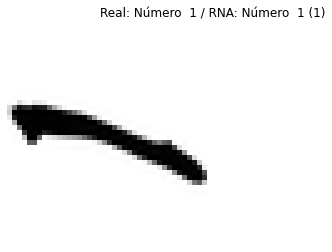

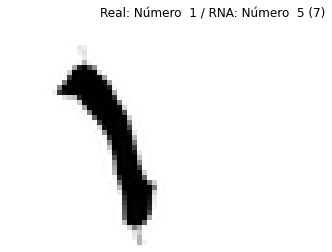

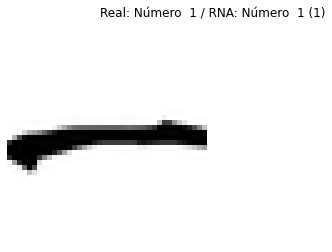

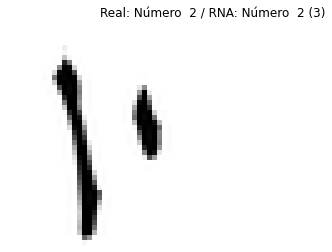

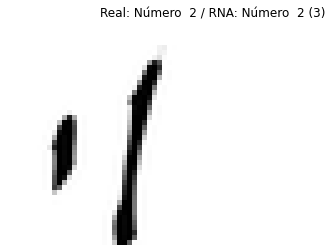

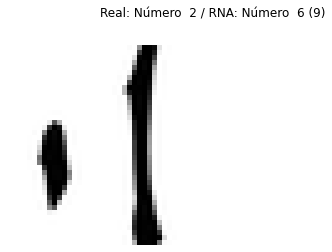

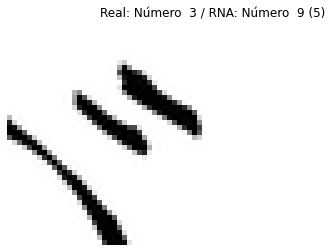

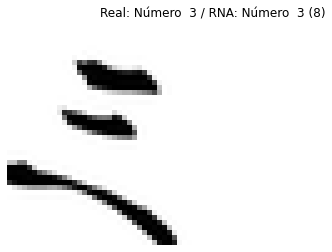

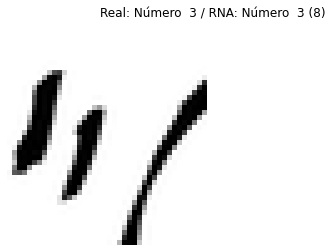

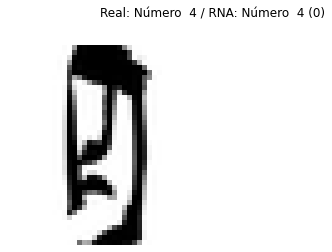

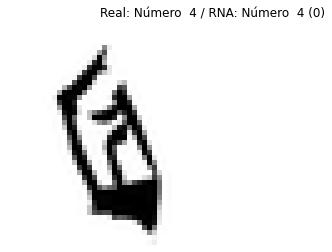

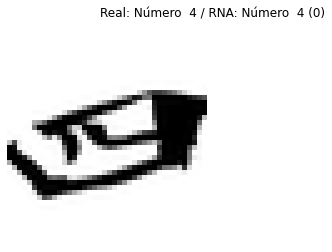

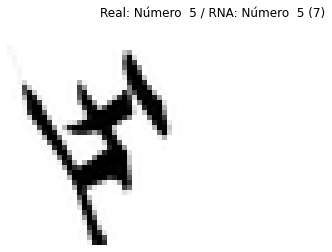

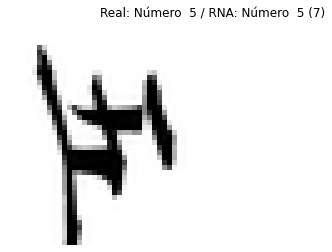

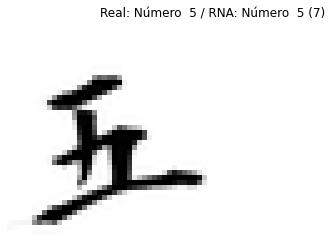

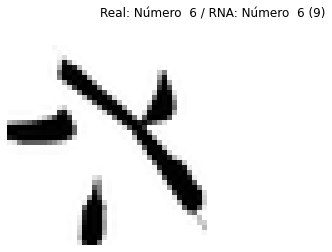

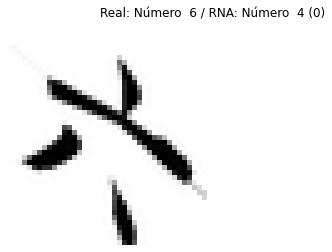

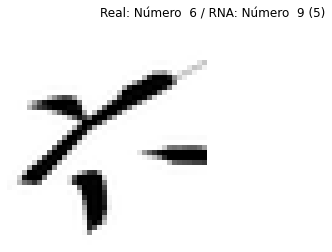

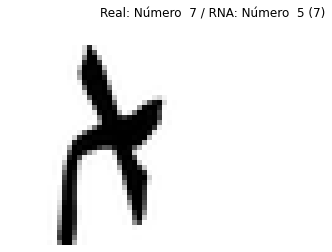

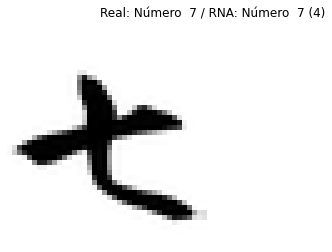

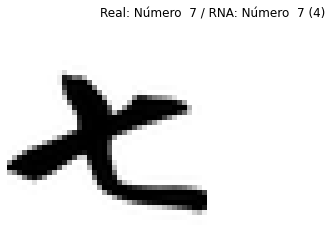

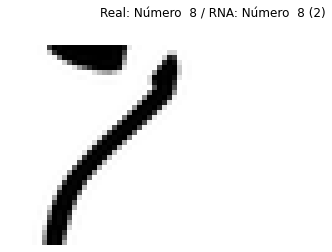

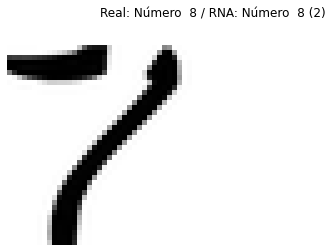

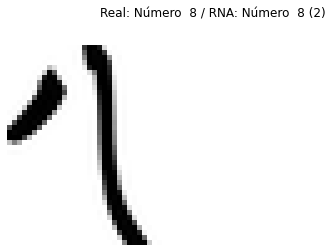

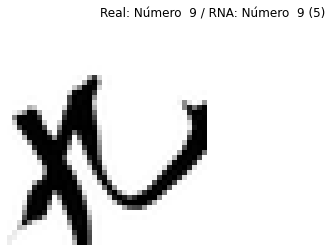

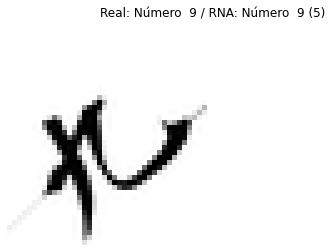

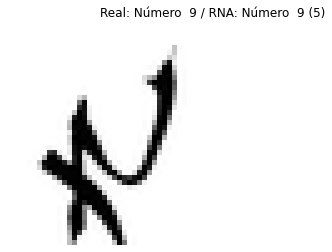

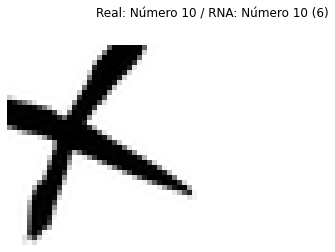

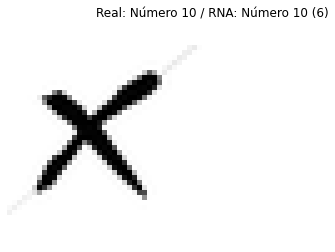

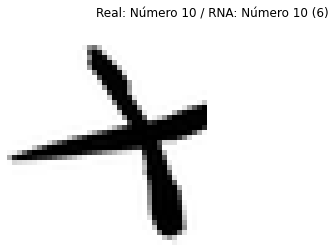

In [11]:
#@title Probar red entrenada con datos de prueba
 
mostrar_detalle_por_imagen = True #@param {type:"boolean"}

 
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, esDAimag_test, clases_map, mostrar_detalle_por_imagen)


1/1 [==============================] - 0s 14ms/step - loss: 0.0171 - accuracy: 1.0000

>Evaluación del Modelo: 
    - Error:  0.017050350084900856
    - Exactitud:  100.0




*** Resultados con datos originales: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

  Número  1       1.00      1.00      1.00         1
  Número  2       1.00      1.00      1.00         1
  Número  3       1.00      1.00      1.00         1
  Número  4       1.00      1.00      1.00         1
  Número  5       1.00      1.00      1.00         1
  Número  6       1.00      1.00      1.00         1
  Número  7       1.00      1.00      1.00         1
  Número  8       1.00      1.00      1.00         1
  Número  9       1.00      1.00      1.00         1
  Número 10       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


,p:Número 1,p:Número 2,p:Número 3,p:Número 4,p:Número 5,p:Número 6,p:Número 7,p:Número 8,p:Número 9,p:Número 10
r:Número 1,1,0,0,0,0,0,0,0,0,0
r:Número 2,0,1,0,0,0,0,0,0,0,0
r:Número 3,0,0,1,0,0,0,0,0,0,0
r:Número 4,0,0,0,1,0,0,0,0,0,0
r:Número 5,0,0,0,0,1,0,0,0,0,0
r:Número 6,0,0,0,0,0,1,0,0,0,0
r:Número 7,0,0,0,0,0,0,1,0,0,0
r:Número 8,0,0,0,0,0,0,0,1,0,0
r:Número 9,0,0,0,0,0,0,0,0,1,0
r:Número 10,0,0,0,0,0,0,0,0,0,1





>Resultados: 


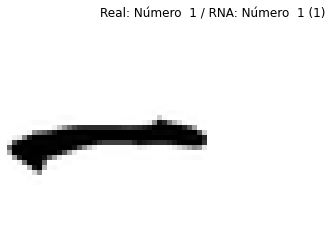

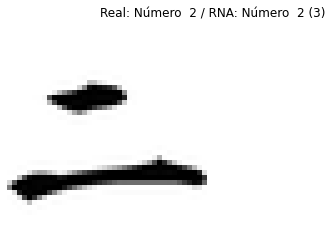

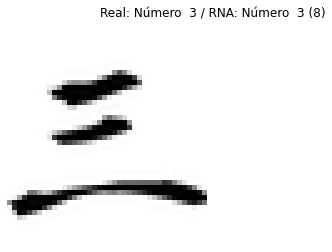

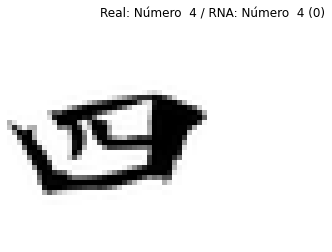

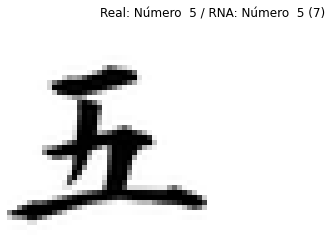

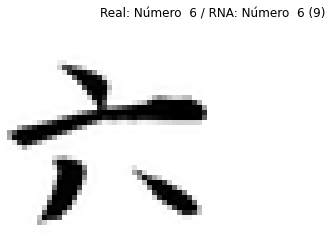

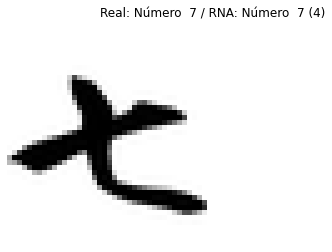

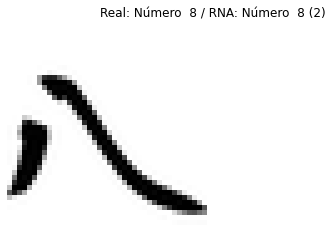

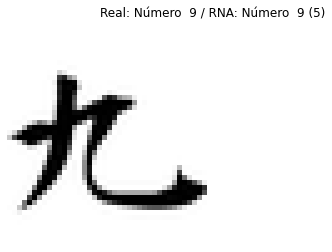

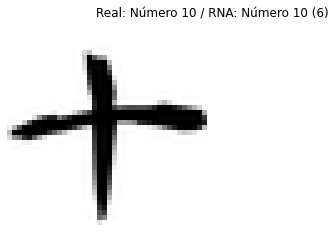

In [12]:
#@title Probar red entrenada con datos originales (sin DA)

# carga las imagenes de entrenamiento
classes_ori, images_ori, esDAimag_ori, tipoImage_ori = cargarImagenes(imagPath_auxi)
x_ori = prepare_imageList(images_ori)
y_ori, y_oriEnc,_ = prepare_clasesList(classes_ori, dictMapeo)

 # evalua al modelo entrenado
resEval = model.evaluate(x_ori, (y_oriEnc if tipo_output_softMax else y_ori),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos originales: ")
probarModelo(x_ori, y_ori, esDAimag_ori, clases_map, True)
